# Introduction
In this tutorial, we will learn how to use the PuLP library in Python to solve linear programming problems. Linear programming is a method to achieve the best outcome in a mathematical model whose requirements are represented by linear constraints.

In [1]:
#Install pulp
%pip install pulp


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import the library
import random
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus

# Fourth example: A simplified version of the UTA method

The following is an example code solving the problem of ranking alternatives using the UTA method. Consider a problem with two competing criteria C_1 and C_2.

The following example demonstrates the application of the UTA method for ranking alternatives based on two competing criteria, $C_1$ and $C_2$.  

- Criterion $C_1$ is evaluated using numerical values \($[0, 25, 50, 75, 100]$ (0: least preferred, 100: most preferred)\),

- Criterion $C_2$ is assessed using qualitative ratings \($['Bad', 'Poor', 'Neutral', 'Good', 'Excellent']$ ('Bad': worst, 'Excellent': best)\).

Both criteria are relevant, but their weights can not exceed $0.75$.

In this example, four reference alternatives are randomly assigned values from the available criteria levels. In real-world applications, these values would be determined by a decision maker.

Additionally, the decision maker provides preference information, stating that:
-  $a_1 > a_2$
-  $a_1 > a_3$
-  $a_2 > a_4$

The objective of this setup is not to optimize some objective function but rather to verify whether a system of equations satisfying these preferences has a feasible solution.

Run this example several times and see that for some data sets there is a solution and for some the system of equations is contradictory.

# Weronika Koga 151574

# Zapraszam do wzięcia udziału w podróży moich prób i błędów.

Disclaimer - podróż zaczyna się od 0, a więc nawet jeśli na danym etapie coś wydaje się absolutnie źle, jest wciąż szansa, że zauważyłam to później i poprawiłam. Chciałam jednak pokazać ile pracy w to włożyłam na wypadek gdybym została posądzona przez bezlitosne narzędzie antyplagiatowe o plagiat.

Legenda:
* czesc 0 - pomijalna
* czesc 1 - kierowanie sie wyłącznie maksymalizacją sumy użyteczności wszystkich wariantów (czemu? Bo zbłądziłam)
* część 2 - maksymalizacja epsilona

In [3]:
# czesc 0 - zmienne i dane ktore predzej czy pozniej w swojej nieuwadze i przemęczeniu przypadkiem nadpisze, znajduja sie tu abym mogla je odzyskac. Nic ciekawego.

import pandas as pd
import numpy as np 

# Ustawienia wyświetlania tabeli w jednym wierszu
pd.set_option('display.max_columns', None)  # Wyświetl wszystkie kolumny
pd.set_option('display.expand_frame_repr', False)  # Nie zawijaj wierszy

# Dane wejściowe referencyjne
data_ref = {
    "index": [13, 25, 3, 26, 5, 16, 2, 19, 10, 21],
    "C1": [0.48, 0.34, 1.00, 0.71, 0.62, 0.44, 0.66, 0.35, 0.45, 0.83],
    "C2": [0.97, 1.00, 0.45, 0.25, 0.40, 0.95, 0.55, 0.91, 0.86, 0.25],
    "C3": [0.00, 1.00, 0.57, 0.88, 0.56, 0.00, 0.45, 0.00, 0.00, 0.80],
}
df = pd.DataFrame(data_ref)

# Moglam zrobic skale z krokiem, ale ludzie robili dynamicznie a ze robie sama to ich opinia moze byc jakakolwiek pomoca
all_vals = np.concatenate([df["C1"], df["C2"], df["C3"]])
scale = np.sort(np.unique(np.round(all_vals, 2)))
print("Dynamiczna skala:", scale)

Dynamiczna skala: [0.   0.25 0.34 0.35 0.4  0.44 0.45 0.48 0.55 0.56 0.57 0.62 0.66 0.71
 0.8  0.83 0.86 0.88 0.91 0.95 0.97 1.  ]


Epsilon = 1e-08, status = Optimal, objective = 8.899999959999999
Epsilon = 0.01, status = Optimal, objective = 8.85
Epsilon = 0.05, status = Optimal, objective = 8.65
Epsilon = 1, status = Infeasible, objective = 3.0
Epsilon = 0.1, status = Optimal, objective = 8.4
Epsilon = 0.2, status = Optimal, objective = 7.8
Epsilon = 0.333, status = Optimal, objective = 7.002

Najlepsza wartość funkcji celu: 8.9000 dla epsilon = 1e-08

Tabela rankingów:
Epsilon  Epsilon 1e-08  Epsilon 0.01  Epsilon 0.05  Epsilon 1  Epsilon 0.1  Epsilon 0.2  Epsilon 0.333
Wariant                                                                                               
13                   1             4             4          5            4            4              4
25                  10            10            10         10           10           10             10
3                    8             8             8          1            5            5              5
26                   9             9  

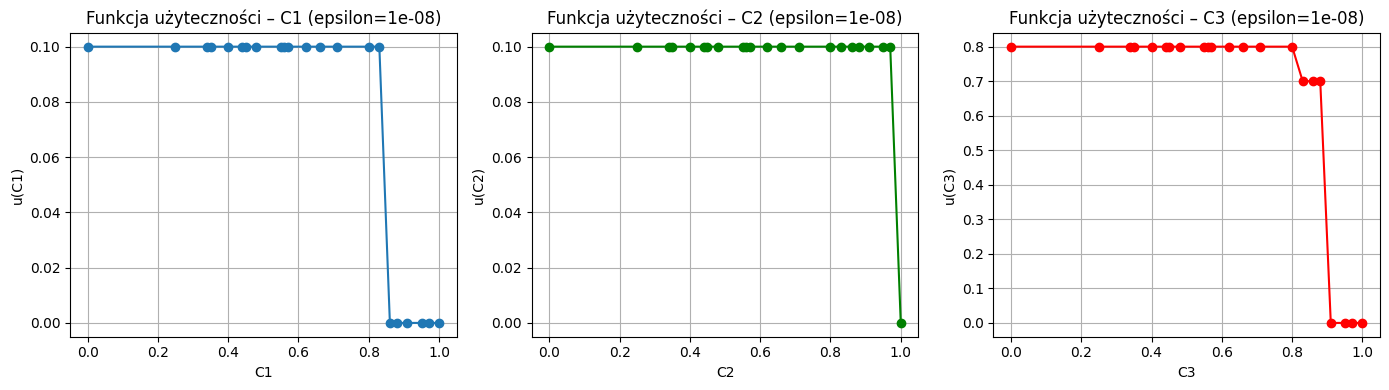

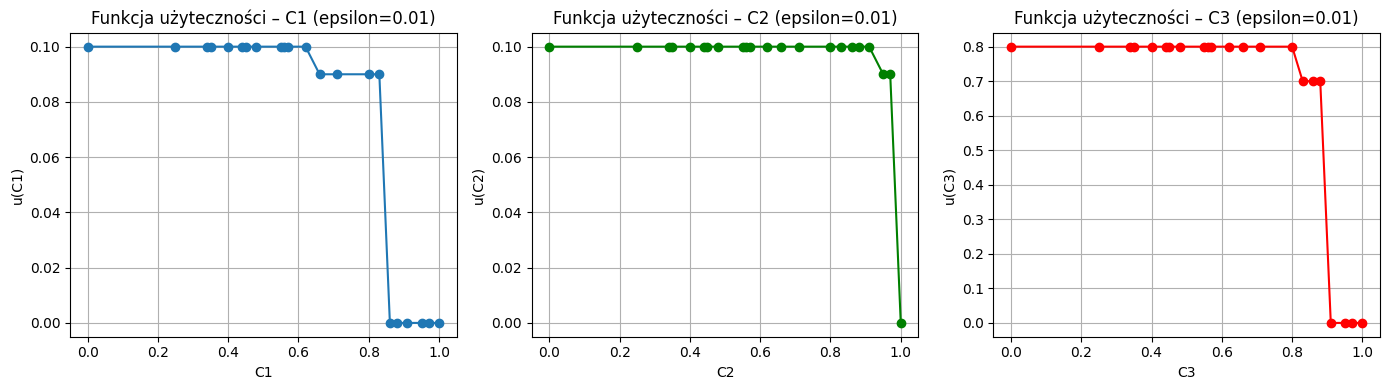

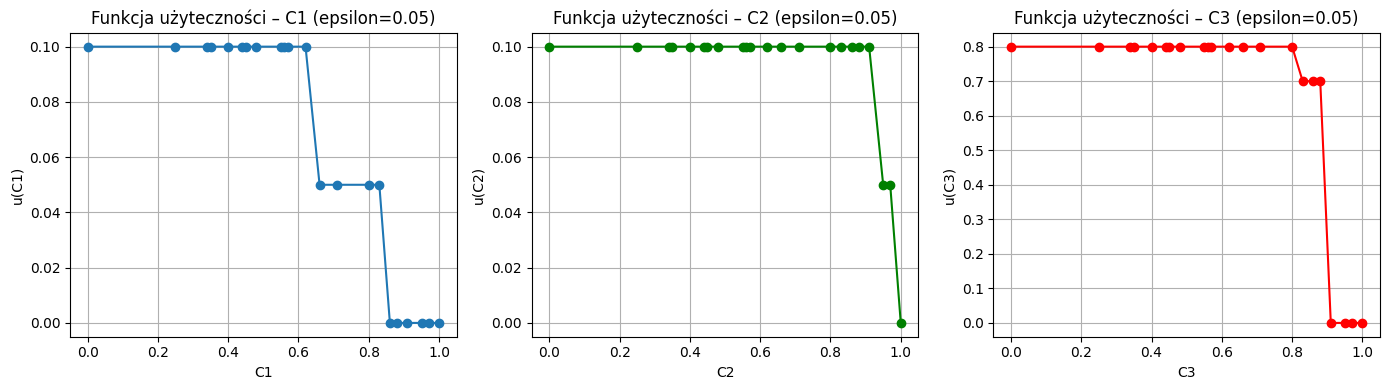

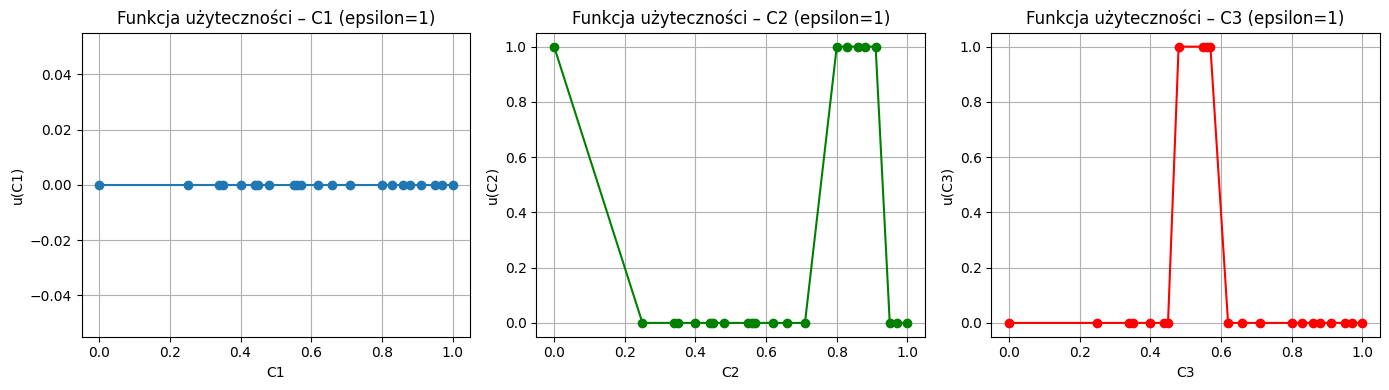

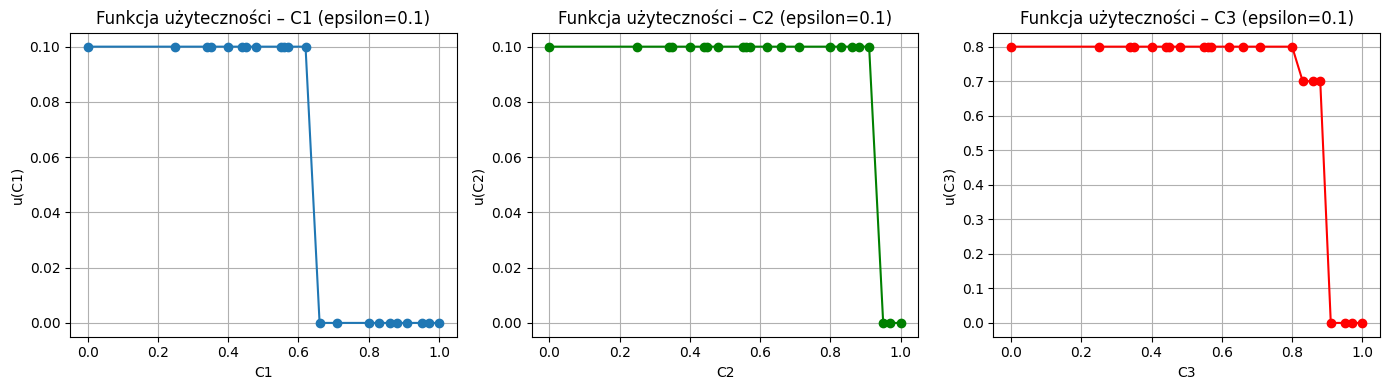

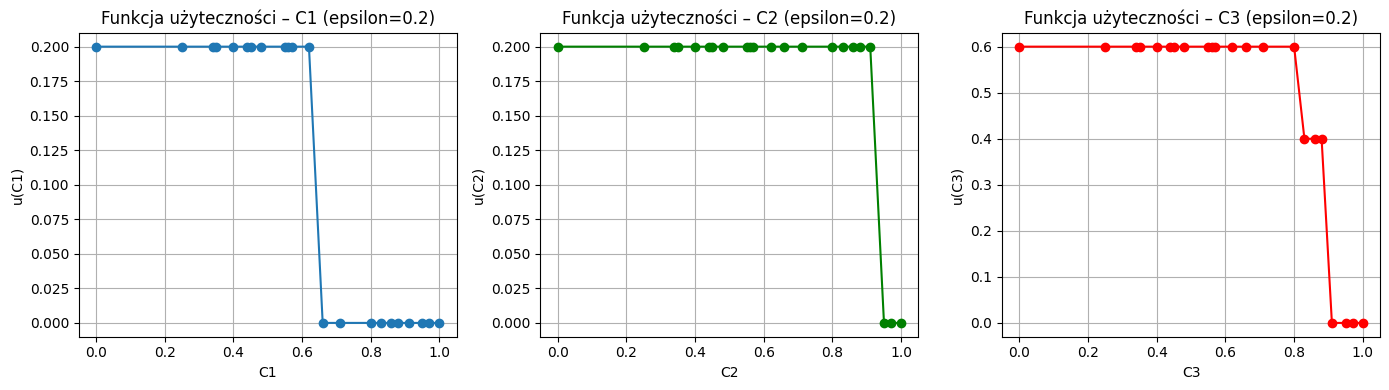

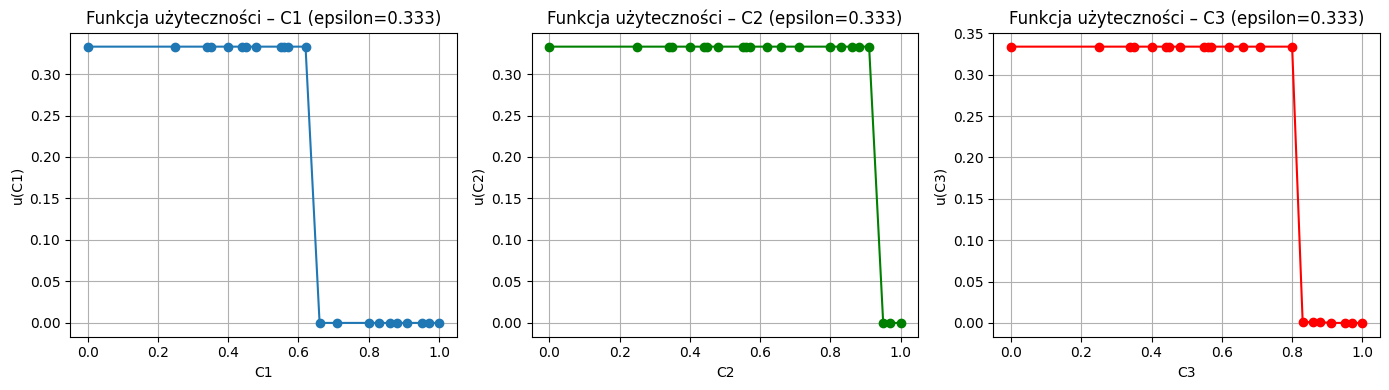

In [108]:
# Lista indeksów moich wariantów oraz epsilony na których będę testować
variant_indices = df["index"].tolist()
eps = [0.00000001, 0.01, 0.05, 1, 0.1, 0.2, 0.333]

# Słownik do przechowywania pozycji wariantów dla każdego epsilon
rankings_table = {variant: [] for variant in variant_indices}

best_objective = -float('inf')  # Najlepsza wartość funkcji celu
best_epsilon = None  # Epsilon dla najlepszej wartości funkcji celu

# Zmienna do przechowywania najlepszych funkcji cząstkowych
best_u_C1_vals = None
best_u_C2_vals = None
best_u_C3_vals = None

# Słowniki do przechowywania funkcji cząstkowych dla każdego epsilon
all_u_C1_vals = {}
all_u_C2_vals = {}
all_u_C3_vals = {}

for epsilon in eps:
    # Problem optymalizacyjny
    prob = LpProblem("UTA_Method", LpMaximize)

    # Zmienne decyzyjne – cząstkowe funkcje użyteczności
    u_C1 = {val: LpVariable(f"u_C1_{val}", lowBound=0, upBound=1) for val in scale}
    u_C2 = {val: LpVariable(f"u_C2_{val}", lowBound=0, upBound=1) for val in scale}
    u_C3 = {val: LpVariable(f"u_C3_{val}", lowBound=0, upBound=1) for val in scale}

    # Monotoniczność odwrotna (koszt – im wyżej, tym gorzej)
    for i in range(len(scale) - 1):
        prob += u_C1[scale[i]] >= u_C1[scale[i + 1]]
        prob += u_C2[scale[i]] >= u_C2[scale[i + 1]]
        prob += u_C3[scale[i]] >= u_C3[scale[i + 1]]

    prob += u_C1[1] == 0
    prob += u_C2[1] == 0
    prob += u_C3[1] == 0
    prob += u_C1[0] + u_C2[0] + u_C3[0] == 1
    prob += u_C1[0] >= 0.1
    prob += u_C2[0] >= 0.1
    prob += u_C3[0] >= 0.1

    # Funkcja do interpolacji
    def interpolate(val, u_dict):
        lower = max([v for v in scale if v <= val])
        upper = min([v for v in scale if v >= val])
        if lower == upper:
            return u_dict[lower]
        alpha = (val - lower) / (upper - lower)
        return (1 - alpha) * u_dict[lower] + alpha * u_dict[upper]

    # Zmienne dla użyteczności wariantów
    utilities = {}
    for i, row in df.iterrows():
        idx = int(row["index"])
        util = LpVariable(f"U_{idx}", lowBound=0, upBound=1)
        utilities[idx] = util

        uc1 = interpolate(row["C1"], u_C1)
        uc2 = interpolate(row["C2"], u_C2)
        uc3 = interpolate(row["C3"], u_C3)
        prob += util == uc1 + uc2 + uc3

    # Preferencje lokalizacyjne R2 > R1 > R3
    prob += utilities[13] >= utilities[25] + epsilon  # R2 > R3
    prob += utilities[3] >= utilities[26] + epsilon  # R1 > R3
    prob += utilities[5] >= utilities[16] + epsilon  # R2 > R3

    # Preferencje finansowania F1 > F2 > F3
    prob += utilities[19] >= utilities[2] + epsilon  # F1 > F2
    prob += utilities[10] >= utilities[21] + epsilon  # F1 > F3

    # Funkcja celu – maksymalizacja sumy użyteczności
    prob += lpSum([utilities[k] for k in utilities])

    # Rozwiązywanie
    prob.solve()

    # Zapisanie wyników dla tego epsilon
    utility_values = {k: value(v) for k, v in utilities.items()}
    ranking = sorted(utility_values.items(), key=lambda x: x[1], reverse=True)

    # Zapisanie rankingu dla każdego wariantu
    for rank, (idx, val) in enumerate(ranking, 1):
        rankings_table[idx].append(rank)

    # Zapisanie funkcji cząstkowych dla tego epsilon
    all_u_C1_vals[epsilon] = {val: value(u_C1[val]) for val in scale}
    all_u_C2_vals[epsilon] = {val: value(u_C2[val]) for val in scale}
    all_u_C3_vals[epsilon] = {val: value(u_C3[val]) for val in scale}

    # Sprawdzenie, czy to najlepsza wartość funkcji celu
    if value(prob.objective) > best_objective:
        best_objective = value(prob.objective)
        best_epsilon = epsilon

        # Nadpisanie najlepszych funkcji cząstkowych
        best_u_C1_vals = all_u_C1_vals[epsilon]
        best_u_C2_vals = all_u_C2_vals[epsilon]
        best_u_C3_vals = all_u_C3_vals[epsilon]

    print(f"Epsilon = {epsilon}, status = {LpStatus[prob.status]}, objective = {value(prob.objective)}")

# Wyświetlenie najlepszej wartości funkcji celu i epsilon
print(f"\nNajlepsza wartość funkcji celu: {best_objective:.4f} dla epsilon = {best_epsilon}")

# Nadpisanie u_C_vals_old najlepszymi funkcjami cząstkowymi
u_C1_vals_old = best_u_C1_vals
u_C2_vals_old = best_u_C2_vals
u_C3_vals_old = best_u_C3_vals

# Tworzenie tabeli z rankingami
rankings_df = pd.DataFrame(rankings_table, index=[f"Epsilon {e}" for e in eps]).T
rankings_df.index.name = "Wariant"
rankings_df.columns.name = "Epsilon"

# Wyświetlenie tabeli
print("\nTabela rankingów:")
print(rankings_df)

# Rysowanie wykresów dla każdego epsilon
for epsilon in eps:
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(scale, list(all_u_C1_vals[epsilon].values()), 'o-', label=f'C1 (epsilon={epsilon})')
    plt.title(f"Funkcja użyteczności – C1 (epsilon={epsilon})")
    plt.xlabel("C1"); plt.ylabel("u(C1)"); plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(scale, list(all_u_C2_vals[epsilon].values()), 'o-', label=f'C2 (epsilon={epsilon})', color='g')
    plt.title(f"Funkcja użyteczności – C2 (epsilon={epsilon})")
    plt.xlabel("C2"); plt.ylabel("u(C2)"); plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(scale, list(all_u_C3_vals[epsilon].values()), 'o-', label=f'C3 (epsilon={epsilon})', color='r')
    plt.title(f"Funkcja użyteczności – C3 (epsilon={epsilon})")
    plt.xlabel("C3"); plt.ylabel("u(C3)"); plt.grid()

    plt.tight_layout()
    plt.show()

Status = Optimal, Wartość funkcji celu (epsilon) = 0.3333

Ranking wariantów (od najlepszego):
1. Wariant 5: Użyteczność = 1.0000
2. Wariant 13: Użyteczność = 0.6667
3. Wariant 3: Użyteczność = 0.6667
4. Wariant 16: Użyteczność = 0.6667
5. Wariant 19: Użyteczność = 0.6667
6. Wariant 10: Użyteczność = 0.6667
7. Wariant 25: Użyteczność = 0.3333
8. Wariant 26: Użyteczność = 0.3333
9. Wariant 2: Użyteczność = 0.3333
10. Wariant 21: Użyteczność = 0.3333


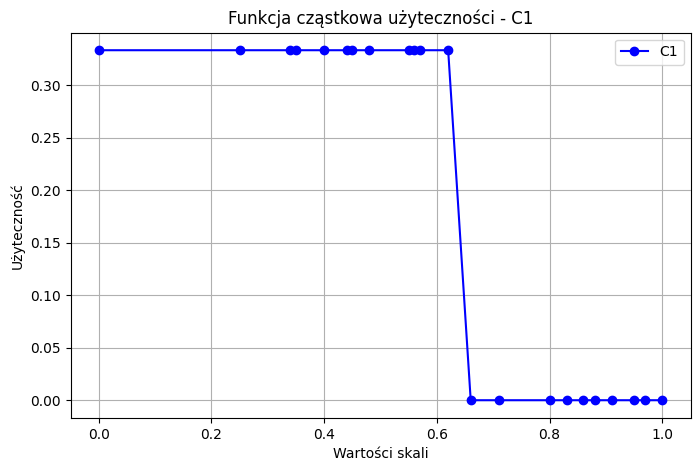

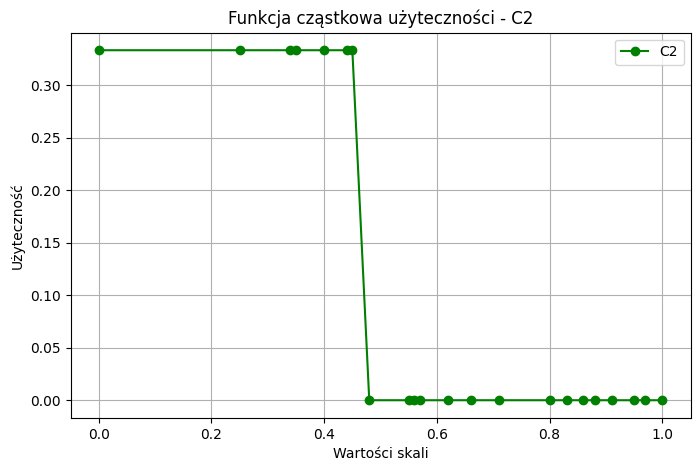

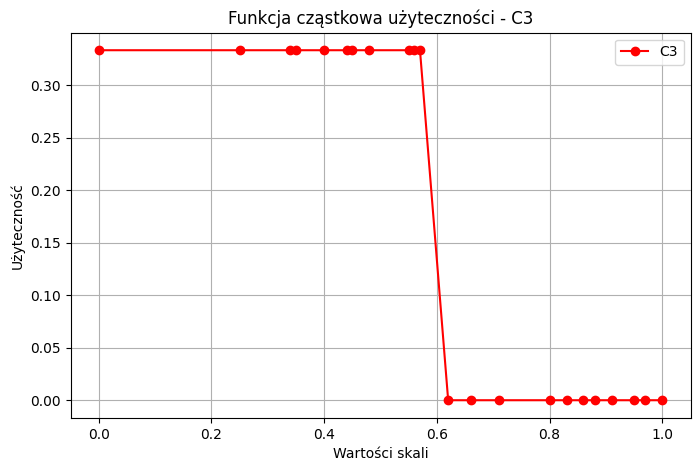

In [ ]:
# Czesc 2 UTA w mam nadzieje sensownej wersji

# Zmienna do przechowywania wyników dla różnych epsilon
rankings_table = {variant: [] for variant in df["index"].tolist()}

# Problem optymalizacyjny
prob = LpProblem("UTA_Method", LpMaximize)

# Zmienne decyzyjne – cząstkowe funkcje użyteczności
u_C1 = {val: LpVariable(f"u_C1_{val}", lowBound=0, upBound=1) for val in scale}
u_C2 = {val: LpVariable(f"u_C2_{val}", lowBound=0, upBound=1) for val in scale}
u_C3 = {val: LpVariable(f"u_C3_{val}", lowBound=0, upBound=1) for val in scale}

# Zmienna decyzyjna dla epsilon
epsilon = LpVariable("epsilon", lowBound=0)

# Monotoniczność odwrotna (koszt – im wyżej, tym gorzej)
for i in range(len(scale) - 1):
    prob += u_C1[scale[i]] >= u_C1[scale[i + 1]]
    prob += u_C2[scale[i]] >= u_C2[scale[i + 1]]
    prob += u_C3[scale[i]] >= u_C3[scale[i + 1]]

prob += u_C1[1] == 0
prob += u_C2[1] == 0
prob += u_C3[1] == 0
prob += u_C1[0] + u_C2[0] + u_C3[0] == 1
prob += u_C1[0] >= 0.1
prob += u_C2[0] >= 0.1
prob += u_C3[0] >= 0.1

# Funkcja do interpolacji
def interpolate(val, u_dict):
    lower = max([v for v in scale if v <= val])
    upper = min([v for v in scale if v >= val])
    if lower == upper:
        return u_dict[lower]
    alpha = (val - lower) / (upper - lower)
    return (1 - alpha) * u_dict[lower] + alpha * u_dict[upper]

# Zmienne dla użyteczności wariantów
utilities = {}
for i, row in df.iterrows():
    idx = int(row["index"])
    util = LpVariable(f"U_{idx}", lowBound=0, upBound=1)
    utilities[idx] = util

    uc1 = interpolate(row["C1"], u_C1)
    uc2 = interpolate(row["C2"], u_C2)
    uc3 = interpolate(row["C3"], u_C3)
    prob += util == uc1 + uc2 + uc3

# Preferencje lokalizacyjne R2 > R1 > R3
prob += utilities[13] >= utilities[25] + epsilon  # R2 > R3
prob += utilities[3]  >= utilities[26] + epsilon  # R1 > R3
prob += utilities[5]  >= utilities[16] + epsilon  # R2 > R3

# Preferencje finansowania F1 > F2 > F3
prob += utilities[19] >= utilities[2]  + epsilon  # F1 > F2
prob += utilities[10] >= utilities[21] + epsilon  # F1 > F3

# Funkcja celu – maksymalizacja epsilon
prob += epsilon

# Rozwiązywanie
prob.solve()

# Podsumowanie wyników optymalizacji
print(f"Status = {LpStatus[prob.status]}, Wartość funkcji celu (epsilon) = {value(prob.objective):.4f}")

# Zapisanie wyników
utility_values = {k: value(v) for k, v in utilities.items()}
ranking = sorted(utility_values.items(), key=lambda x: x[1], reverse=True)

# Nadpisanie funkcji cząstkowych z części 1 gdybym chciala wyswietlic czesc 3 dla maksymalizacji epsilona
u_C1_vals_new = {val: value(u_C1[val]) for val in scale}
u_C2_vals_new = {val: value(u_C2[val]) for val in scale}
u_C3_vals_new = {val: value(u_C3[val]) for val in scale}

# Zapisanie rankingu dla każdego wariantu
for rank, (idx, val) in enumerate(ranking, 1):
    rankings_table[idx].append(rank)

# Wyświetlenie wyników
print("\nRanking wariantów (od najlepszego):")
for rank, (idx, val) in enumerate(ranking, 1):
    print(f"{rank}. Wariant {idx}: Użyteczność = {val:.4f}")

# Tworzenie tabeli z rankingami
rankings_df = pd.DataFrame(rankings_table, index=["Ranking"]).T
rankings_df.index.name = "Wariant"
rankings_df.columns.name = "Ranking"

# Wykres dla C1
plt.figure(figsize=(8, 5))
plt.plot(scale, [u_C1_vals_new[val] for val in scale], marker='o', color='blue', label="C1")
plt.title("Funkcja cząstkowa użyteczności - C1")
plt.xlabel("Wartości skali")
plt.ylabel("Użyteczność")
plt.grid(True)
plt.legend()
plt.show()

# Wykres dla C2
plt.figure(figsize=(8, 5))
plt.plot(scale, [u_C2_vals_new[val] for val in scale], marker='o', color='green', label="C2")
plt.title("Funkcja cząstkowa użyteczności - C2")
plt.xlabel("Wartości skali")
plt.ylabel("Użyteczność")
plt.grid(True)
plt.legend()
plt.show()

# Wykres dla C3
plt.figure(figsize=(8, 5))
plt.plot(scale, [u_C3_vals_new[val] for val in scale], marker='o', color='red', label="C3")
plt.title("Funkcja cząstkowa użyteczności - C3")
plt.xlabel("Wartości skali")
plt.ylabel("Użyteczność")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# cześć 3 - UTA z danymi rzeczywistymi
all_data = {
    "index": list(range(1, 28)),
    "C1": [0.60, 0.66, 1.00, 0.48, 0.62, 0.78, 0.40, 0.64, 0.65, 0.45,
           0.61, 0.74, 0.48, 0.69, 0.87, 0.44, 0.68, 0.76, 0.35, 0.64,
           0.83, 0.32, 0.59, 0.73, 0.34, 0.71, 0.80],
    "C2": [0.93, 0.55, 0.45, 0.87, 0.40, 0.27, 0.90, 0.44, 0.30, 0.86,
           0.54, 0.25, 0.97, 0.49, 0.03, 0.95, 0.40, 0.06, 0.91, 0.22,
           0.25, 0.83, 0.24, 0.03, 1.00, 0.25, 0.06],
    "C3": [0.00, 0.45, 0.57, 0.00, 0.56, 0.71, 0.00, 0.54, 0.71, 0.00,
           0.38, 0.80, 0.00, 0.56, 1.00, 0.00, 0.65, 1.00, 0.00, 0.81,
           0.80, 0.00, 0.70, 1.00, 1.00, 0.88, 1.00],
}
df_new = pd.DataFrame(all_data)

# Obliczanie użyteczności nowych wariantów
def interpolated_value(val, scale, u_dict):
    lower = max([v for v in scale if v <= val])
    upper = min([v for v in scale if v >= val])
    if lower == upper:
        return u_dict[lower]
    alpha = (val - lower) / (upper - lower)
    return (1 - alpha) * u_dict[lower] + alpha * u_dict[upper]

# Obliczanie użyteczności nowych wariantów dla u_C_vals_old
results_old = []
for i, row in df_new.iterrows():
    uc1_old = interpolated_value(row["C1"], scale, u_C1_vals_old)
    uc2_old = interpolated_value(row["C2"], scale, u_C2_vals_old)
    uc3_old = interpolated_value(row["C3"], scale, u_C3_vals_old)
    total_old = uc1_old + uc2_old + uc3_old
    results_old.append({"Wariant": row["index"], "Użyteczność_old": round(total_old, 4)})

df_results_old = pd.DataFrame(results_old).sort_values(by="Użyteczność_old", ascending=False).reset_index(drop=True)

# Obliczanie użyteczności nowych wariantów dla u_C_vals_new
results_new = []
for i, row in df_new.iterrows():
    uc1_new = interpolated_value(row["C1"], scale, u_C1_vals_new)
    uc2_new = interpolated_value(row["C2"], scale, u_C2_vals_new)
    uc3_new = interpolated_value(row["C3"], scale, u_C3_vals_new)
    total_new = uc1_new + uc2_new + uc3_new
    results_new.append({"Wariant": row["index"], "Użyteczność_new": round(total_new, 4)})

df_results_new = pd.DataFrame(results_new).sort_values(by="Użyteczność_new", ascending=False).reset_index(drop=True)


# Porównanie rankingów
comparison = pd.merge(
    df_results_old.rename(columns={"Użyteczność_old": "Użyteczność", "index": "Wariant"}).reset_index(),
    df_results_new.rename(columns={"Użyteczność_new": "Użyteczność", "index": "Wariant"}).reset_index(),
    on="Wariant",
    suffixes=("_old", "_new")
)

# Dodanie pozycji w rankingu na podstawie sortowania
comparison["Ranking_old"] = comparison["Użyteczność_old"].rank(ascending=False, method="dense").astype(int)
comparison["Ranking_new"] = comparison["Użyteczność_new"].rank(ascending=False, method="dense").astype(int)

# Posortowanie tabeli według wariantów dla czytelności
comparison = comparison.sort_values(by="Wariant").reset_index(drop=True)

# Grupowanie dla Ranking_new
ranking_new_groups = comparison.groupby("Ranking_new")["Wariant"].apply(list)

print("Ranking_new:")
for rank, variants in ranking_new_groups.items():
    print(f"Miejsce {rank}: {variants}")

# Grupowanie dla Ranking_old
ranking_old_groups = comparison.groupby("Ranking_old")["Wariant"].apply(list)

print("\nRanking_old:")
for rank, variants in ranking_old_groups.items():
    print(f"Miejsce {rank}: {variants}")
    
    
print("\nPorównanie użyteczności:")
print(comparison[["Wariant", "Użyteczność_old", "Użyteczność_new"]])


Ranking_new:
Miejsce 1: [5.0]
Miejsce 2: [8.0]
Miejsce 3: [1.0, 3.0, 4.0, 7.0, 10.0, 11.0, 13.0, 16.0, 19.0, 22.0, 23.0]
Miejsce 4: [20.0]
Miejsce 5: [9.0]
Miejsce 6: [2.0, 6.0, 12.0, 14.0, 15.0, 17.0, 18.0, 21.0, 24.0, 25.0, 26.0, 27.0]

Ranking_old:
Miejsce 1: [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 16.0, 17.0, 19.0, 21.0, 22.0, 23.0]
Miejsce 2: [20.0]
Miejsce 3: [3.0, 26.0]
Miejsce 4: [18.0, 24.0, 27.0]
Miejsce 5: [15.0, 25.0]

Porównanie użyteczności:
    Wariant  Użyteczność_old  Użyteczność_new
0       1.0           1.0000           0.6667
1       2.0           1.0000           0.3333
2       3.0           0.9000           0.6667
3       4.0           1.0000           0.6667
4       5.0           1.0000           1.0000
5       6.0           1.0000           0.3333
6       7.0           1.0000           0.6667
7       8.0           1.0000           0.8333
8       9.0           1.0000           0.4167
9      10.0           1.0000           0.6667
10 

# Sprawozdanie

### Krótki opis informacji preferencyjnej

**Przypomnienie preferencji decydenta**
- Preferencje lokalizacyjne R2 > R1 > R3
- Preferencja finansowania F1 > F2 > F3 (z tego co przeanalizowałam tekst artykułów, dobrałam taką kolejność)

    - F1 jest najlepsze bo skoro wydajność energii wzrośnie w przyszłości to więcej środków będzie wpływało do funduszu powierniczego który gromadzi tam odsetki, i zabezpiecza środki aby unikać pożyczek

    - F2 jest średnie bo na bieżąco płaci się w miare pojawienia się kosztów, więc nie korzysta z akumulacji pieniędzy, ale też unika kredytów

    - F3 wymaga kredytu

    Czy jest to poprawny wybór? Ekonomistką nie jestem ale dodatkowym atutem tej koleności było ograniczenie konieczności przypominania sobie co jest lepsze jak w przypadku lokalizacji. 1,2,3 wydaje się bardziej naturalną kolejnością niż 2,1,3 i przyśpiesza mi analizowanie tych wyników. Ale to tak na marginesie. 

**Jakie pary wariantów zostały wybrane do oceny i jak zostały ocenione?**
- wybrałam po 3 pierwsze pary wariantów które były zasugerowane w excelu dla grup badających lokalizacje (13+25, 3+26, 5+16)
- 2 pary do badania finansowania (2+19 bo zostało mi przypisane), 10+21 bo jest pierwsze w excelu która bada też finansowanie.
Zaufałam osobie tworzącej tego excela, że zostało to zrobione z przemyślunkiem, nie losowo. Miałam też dzięki temu pewność że pomiędzy parami nie będzie remisu

**Dodatkowe informacje**
- kryteria C1, C2, C3 mają taką samą ważność, z ograniczeniem lowBound=0 i upBound=1 aby zmieścić je w przedziale [0,1]
- zastosowano warunek u_C1[0] + u_C2[0] + u_C3[0] == 1 który normalizuje sume wag do 1
- minimalna waga to 0.1 aby żadne z kryteriów nie było całkowicie pomijane. 
- monotniczność odwrotna funkcji cząstkowych wymusza aby funkcje cząstkowe były nie rosnące, ponieważ mamy doczynienia z kosztem, nie zyskiem

**Maksymalizacja sumy użyteczności vs epsilona**
Zbadanie tego nie było zamierzone, ani nie jest częścią sprawozdania jednak zrobiłam najpierw źle a potem chyba dobrze? Mam nadzieję? I zaobserwowałam, że maksymalizacja sumy użyteczności celu sprawiła, że wszystko jest tam albo idealne, albo prawie idealne, albo okropnie. Brak wartości średnich, raczej same skrajności. Czy jest to przełomowe odkrycie? Nie sądze. Postanowiłam się podzielić, może otrzymam jakiś komentarz. Skoro zmarnowałam już tyle czasu na ten błąd to może się na nim nauczę czegoś jeszcze jak się nim podzielę



### Wynik uzyskany z solvera

Old = podejscie maksymalizujace całkowitą sume użyteczności wariantów

New = podejscie maksymalizujace epsilona

**wartości użyteczności wszystkich wariantów zarówno referencyjnych jak i niereferencyjnych**


| Wariant | Użyteczność_old | Użyteczność_new |
|---------|------------------|------------------|
| 1       | 1.0000           | 0.6667           |
| 2       | 1.0000           | 0.3333           |
| 3       | 0.9000           | 0.6667           |
| 4       | 1.0000           | 0.6667           |
| 5       | 1.0000           | 1.0000           |
| 6       | 1.0000           | 0.3333           |
| 7       | 1.0000           | 0.6667           |
| 8       | 1.0000           | 0.8333           |
| 9       | 1.0000           | 0.4167           |
| 10      | 1.0000           | 0.6667           |
| 11      | 1.0000           | 0.6667           |
| 12      | 1.0000           | 0.3333           |
| 13      | 1.0000           | 0.6667           |
| 14      | 1.0000           | 0.3333           |
| 15      | 0.1000           | 0.3333           |
| 16      | 1.0000           | 0.6667           |
| 17      | 1.0000           | 0.3333           |
| 18      | 0.2000           | 0.3333           |
| 19      | 1.0000           | 0.6667           |
| 20      | 0.9667           | 0.5000           |
| 21      | 1.0000           | 0.3333           |
| 22      | 1.0000           | 0.6667           |
| 23      | 1.0000           | 0.6667           |
| 24      | 0.2000           | 0.3333           |
| 25      | 0.1000           | 0.3333           |
| 26      | 0.9000           | 0.3333           |
| 27      | 0.2000           | 0.3333           |

**Rankingi wszystkich wariantów**

maksymalizacja epsilona:
| Miejsce | Warianty                                             |
|---------|------------------------------------------------------|
| 1       | 5                                                    |
| 2       | 8                                                    |
| 3       | 1, 3, 4, 7, 10, 11, 13, 16, 19, 22, 23               |
| 4       | 20                                                   |
| 5       | 9                                                    |
| 6       | 2, 6, 12, 14, 15, 17, 18, 21, 24, 25, 26, 27          |

maksymalizacja funkcji celu:
| Miejsce | Warianty                                             |
|---------|------------------------------------------------------|
| 1       | 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 22, 23 |
| 2       | 20                                                   |
| 3       | 3, 26                                                |
| 4       | 18, 24, 27                                           |
| 5       | 15, 25                                               |

**Wartosci funkcji celu**

8.9000 dla epsilon = 1e-08 - w trakcie eksperymentów gdzie maksymalizowałam sume użyteczności zbadałam 5 różnych, dobranych "na oko", wartości epsilon i ta była najwyższa

Wartość funkcji celu (epsilon) = 0.3333. Trochę za dużo jak na mój gust. Wolałabym aby był w okolicach 0.1 dla większego rozstrzału między opcjami. 

**Wykresy cząstkowych funkcji użyteczności**
Znajdują się wyżej w tym notebooku

### Krótkie podsumowanie wyników

**Który ranking jest bardziej sensowny?**

Rankingi są inne. Który jest lepszy? Rankingi są inne. Ale spróbuje je porównać.


**Ranking nowy**
- Najlepszy element w rankingu nowym [wariant 5] to taki który ma R2 (najlepsza preferencja decydenta) i F2 (druga najlepsza preferencja decydenta). 
- Drugi najlepszy element w tym rankingu [wariant 8] ma lokalizaje R3 (najgorsza) i finansowanie F2 (druga najlepsza). 
- Czemu zatem drugi element znajduje sie tak wysoko? Czemu nie jest gorszy od wariantu 4 który ma R2(najlepsze) i F1 (najlepsze)? Nie wiem 
- Elementy które znajdują się na najdalszym miejscu w rankingu nie mają ani najlepszego finansowania (poza elementem 25, który ma, ale ma najgorszą lokalizację) ani najlepszej lokalizacji (poza elementem 6 który ma, ale ma również najgorsze finansowanie) jest to sensowne

**Ranking stary**
- Najlepsze warianty: Za dużo. Nie widać silnej preferencji lokalizacji (R1-7,R2-7,R3-5). Finansowanie ma lekką przewagę (F1-7,F2-6,F3-4) zgodnie z preferencjami
- Najgorsze warianty: 15 (najlepsza lokalizacja, najgorsze finanoswanie), 25 (najgorsza lokalizacja, najlepsze finansowanie) co jest zgodne z preferencjami.
- Troche za wiele wartosci jest najlepszych.

### Porównanie lokalizacji – zgodność z preferencjami `R2 > R1 > R3`

| Lokalizacja | Warianty                | Średnia pozycja (new)                           | Średnia pozycja (old)                           |
|-------------|--------------------------|--------------------------------------------------|--------------------------------------------------|
| R2          | 4, 13, 14, 22, 23         | 3.0, 3.0, 6.0, 3.0, 3.0 → **3.6**               | 1.0, 1.0, 1.0, 1.0, 1.0 → **1.0**               |
| R1          | 1, 2, 10, 11, 12, 19, 20, 21 | 3.0, 6.0, 3.0, 3.0, 6.0, 3.0, 4.0, 6.0 → **4.25** | 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0 → **1.125** |
| R3          | 3, 5, 6, 7, 8, 9, 15, 16, 17, 18, 24, 25, 26, 27 | 3.0, 1.0, 6.0, 3.0, 2.0, 5.0, 6.0, 3.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0 → **4.64** | 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0, 4.0, 4.0, 5.0, 3.0, 4.0 → **2.36** |

---

### Porównanie preferencji finansowych – `F1 > F2 > F3`

| Finansowanie | Warianty (F*)                    | Średnia pozycja (new)                         | Średnia pozycja (old)                        |
|--------------|----------------------------------|------------------------------------------------|-----------------------------------------------|
| F1           | 1, 4, 7, 10, 13, 16, 19, 22, 25  | 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 6.0 → **3.33** | 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0 → **1.44** |
| F2           | 2, 5, 8, 11, 14, 17, 20, 23, 26  | 6.0, 1.0, 2.0, 3.0, 6.0, 6.0, 4.0, 3.0, 6.0 → **4.11** | 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 3.0 → **1.33** |
| F3           | 3, 6, 9, 12, 15, 18, 21, 24, 27  | 3.0, 6.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0 → **5.56** | 3.0, 1.0, 1.0, 1.0, 5.0, 4.0, 1.0, 4.0, 4.0 → **2.67** |

---

### Porównanie wartości C1–C3 dla najlepszych wariantów z `Ranking_new`

| Wariant | C1   | C2   | C3   | Średnia (C1–C3) |
|---------|------|------|------|------------------|
| 5       | 0.62 | 0.40 | 0.56 | **0.5267**       |
| 8       | 0.64 | 0.44 | 0.54 | **0.5400**       |
| 1       | 0.60 | 0.93 | 0.00 | **0.5100**       |
| 3       | 1.00 | 0.45 | 0.57 | **0.6733**       |
| 4       | 0.48 | 0.87 | 0.00 | **0.4500**       |

---

### Średnie C1, C2, C3 dla wariantów z **Miejsca 1 w `Ranking_old`**

Warianty: 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 22, 23

| Kryterium | Średnia wartość |
|-----------|-----------------|
| **C1**    | 0.5942          |
| **C2**    | 0.5771          |
| **C3**    | 0.4626          |

**Wnioski**: 
Ranking_old był bardziej „spłaszczony” – wszystko na 1. miejscu lub bardzo blisko. Średnie wartości C1,C2,C3 są umiarkowanie niskie, ale rozrzut dość szeroki. Ranking_old nie dyskryminował wariantów z wysokim C1 (np. wariant 3), dlatego selekcja nie była tak wyraźna jak w Ranking_new.
Ranking_new lepiej odzwierciedla preferencję R2 > R1 > R3, mimo że wartości są mniej skupione — wyraźnie R2 ma niższą średnią pozycję.
Ranking_new jest bardziej zgodny z preferencją F1 > F2 > F3, bo średnie pozycje dokładnie odzwierciedlają kolejność F1 < F2 < F3. W ranking_old wszystko było blisko siebie, brakowało rozróżnienia.
Ranking_new jest ogólnie zgodny z preferencją minimalizacji C1–C3, choć niektóre wyjątki mogą wskazywać na duży wpływ jednego czynnika (np. preferowana lokalizacja). 

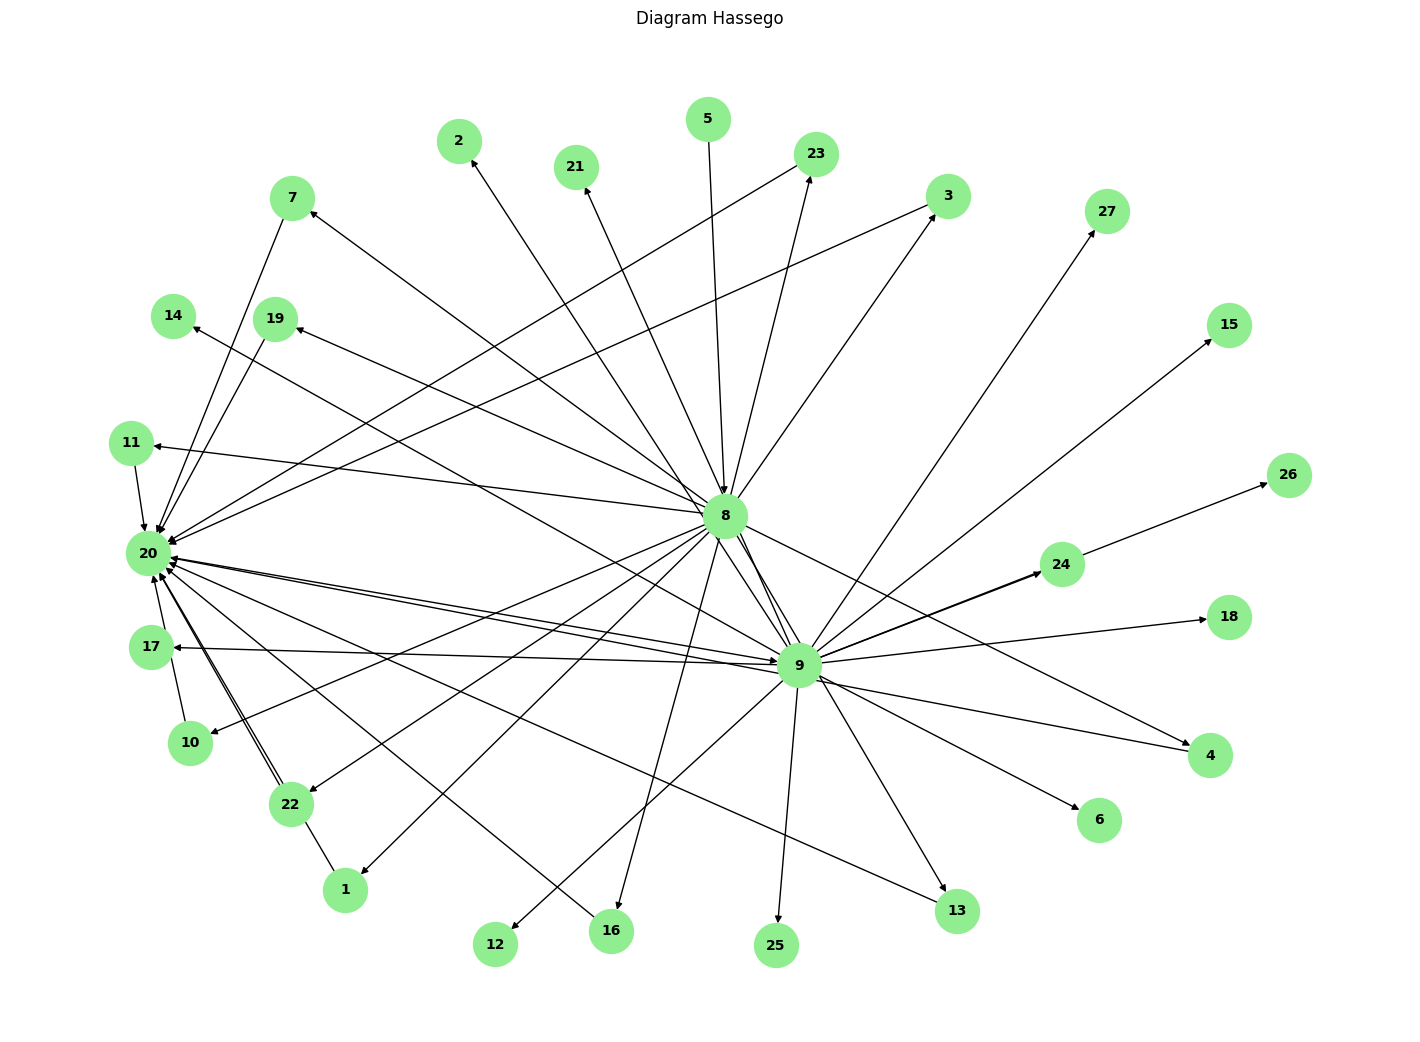

In [112]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Budujemy relacje konieczne z df_results_new
utility_dict = dict(zip(df_results_new["Wariant"], df_results_new["Użyteczność_new"]))

necessary_edges = []
for a, b in combinations(utility_dict.keys(), 2):
    if utility_dict[a] > utility_dict[b]:
        necessary_edges.append((a, b))
    elif utility_dict[b] > utility_dict[a]:
        necessary_edges.append((b, a))

# 2. Tworzenie grafu i usunięcie relacji tranzytywnych
G = nx.DiGraph()
G.add_edges_from(necessary_edges)

def remove_transitive_edges(graph):
    H = graph.copy()
    for u in list(graph.nodes()):
        for v in list(graph.successors(u)):
            for w in list(graph.successors(v)):
                if H.has_edge(u, w):
                    H.remove_edge(u, w)
    return H

H = remove_transitive_edges(G)

# 3. Rozciągnięty układ siatki
pos = nx.spring_layout(H, seed=42, k=2)

# 4. Zmiana etykiet na int
labels = {node: str(int(node)) for node in H.nodes()}

# 5. Rysowanie
plt.figure(figsize=(14, 10))
nx.draw(H, pos,
        labels=labels,         # <-- podmienione etykiety
        with_labels=True,
        arrows=True,
        node_color='lightgreen',
        node_size=1000,
        font_size=10,
        font_weight='bold')
plt.title("Diagram Hassego")
plt.show()


**Opis uzyskanych relacji z diagramu hassego**

Ponieważ usunięto relacje tranzytywne, na diagramie znajdują się tylko bezpośrednie zależności preferencji. Jeśli 8 → 20 i 20 → 17, to nie powinno byc w teorii 8 → 17, bo to relacja pośrednia.

1. Warianty centralne: 8, 9, 20

    - Warianty 8, 9, 20 są najlepiej usytuowane w hierarchii – posiadają najwięcej wychodzących krawędzi.
    - Oznacza to, że są koniecznie lepsze od wielu innych wariantów, niezależnie od konkretnej funkcji użyteczności.

 2. Warianty zdominowane (liście na dole):

    - Warianty takie jak: 2, 21, 27, 15, 26, 18, 6, 25, 12, 22, 17, 14 itd. są celami krawędzi,
    - Co oznacza, że zostały koniecznie uznane za gorsze od innych.
    - Nie posiadają żadnych wychodzących krawędzi – ich pozycja w rankingu jest stabilnie niska.

3. Warianty pośrednie:

    - Warianty takie jak 3, 24, 4, 13, 16, 1, 10, 11, 7, 19, 23:
    - Znajdują się między liderami a liśćmi,
    - Ich relacje są bardziej złożone — z jednymi wygrywają zawsze, z innymi nie ma jednoznacznej relacji.


Czy to jest dobry diagram? Nie jestem pewna. Obiecujące jest to, że 8 jest w centralnych bo faktycznie wypadło wysoko w rankingu zastanawiające, że znajduje się tam 9 z miejsca piątego (ale 8.0 jes lepsze wg tego co rozumiem z wykresu i podobnie dla 20 z miejsca czwartego które też jest gorsze od 8 z 11 po drodze). Czy fakt że do 8.0 wchodzi krawędz z 5.0 oznacza że 5.0 jest lepsze? Z tego co rozumiem to tak. I to by się zgadzało. Warianty które są na wykresie jako zdominowane faktycznie są ostatnie w rankingu. To miło. Próbowałam. 

Robie sama. Jestem po bioinformatyce. Jest trudno.